# Excercise 11: Survival Analysis

In [93]:
import pandas as pd

In [94]:
data = pd.read_csv("../Data/emamma.csv").drop("Unnamed: 0", axis=1)
data.head()

,Age,TIME,Death,Side,CHT,CHT_Type,HT,LR,MTS,MP,HISTOL,Stage,HISTOL_dukct,HISTOL_lob,HISTOL_mod,HISTOL_other
0,47.34,1,1,right,no,no,no,no,no,pre,ductal,first,1.0,0,0,0
1,62.25,2,0,left,yes,CMF,yes,no,no,post,ductal,first,1.0,0,0,0
2,72.25,2,0,right,no,no,yes,no,no,post,ductal,second,1.0,0,0,0
3,61.00,4,1,right,yes,CMF,yes,no,no,post,ductal,second,1.0,0,0,0
4,43.80,4,0,right,yes,CMF,no,no,no,pre,ductal,second,1.0,0,0,0


In [95]:
data.columns = list(col.lower() for col in data.columns)
data['death'] = pd.Series(k == 1 for k in data['death'])

In [96]:
data.dtypes

age             float64
time              int64
death              bool
side             object
cht              object
cht_type         object
ht               object
lr               object
mts              object
mp               object
histol           object
stage            object
histol_dukct    float64
histol_lob        int64
histol_mod        int64
histol_other      int64
dtype: object

## 1 Kaplan-Meier Estimates

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

def plot_survival_functions(data, survival, time, categorical=None):
    if categorical is not None:
        for elem in data[categorical].unique():
            data_subset = data.loc[data[categorical] == elem]
            time_elapsed, survival_prob = kaplan_meier_estimator(data_subset[survival], data_subset[time])
            plt.step(time_elapsed, survival_prob, where="post", label = f"{categorical}={elem}")

    else:
        time_elapsed, survival_prob = kaplan_meier_estimator(data[survival], data[time])
        plt.step(time_elapsed, survival_prob, where="post", label = f"Survival Function")

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="upper right")

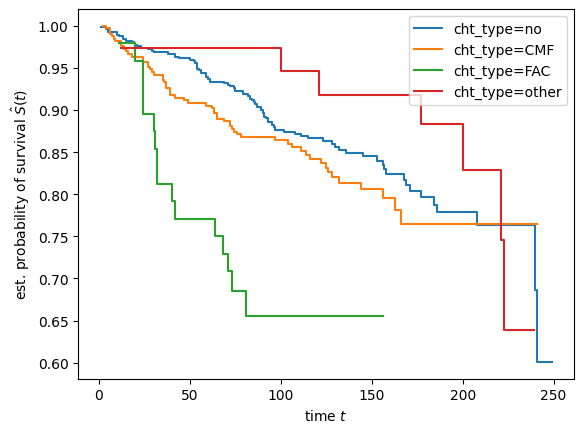

In [98]:
plot_survival_functions(data, 'death', 'time', 'cht_type')

## 2 Multivarate Survival Analysis

In [99]:
data = pd.get_dummies(data, columns=['mp', 'cht'], drop_first=True)
data.columns

Index(['age', 'time', 'death', 'side', 'cht_type', 'ht', 'lr', 'mts', 'histol',
       'stage', 'histol_dukct', 'histol_lob', 'histol_mod', 'histol_other',
       'mp_pre', 'cht_yes'],
      dtype='object')

In [126]:
data[['death', 'time']].to_records(index=False)

rec.array([( True,   1), (False,   2), (False,   2), ( True,   4),
           (False,   4), ( True,   4), ( True,   5), (False,   5),
           ( True,   5), ( True,   6), ( True,   6), ( True,   7),
           (False,   8), ( True,   8), (False,   9), (False,   9),
           ( True,   9), ( True,  10), ( True,  10), (False,  11),
           ( True,  11), ( True,  11), ( True,  12), (False,  12),
           ( True,  12), ( True,  12), ( True,  13), ( True,  13),
           ( True,  14), (False,  15), ( True,  15), ( True,  15),
           ( True,  16), (False,  17), ( True,  18), ( True,  18),
           ( True,  19), ( True,  20), ( True,  20), (False,  20),
           ( True,  21), ( True,  23), (False,  23), ( True,  24),
           ( True,  24), (False,  24), ( True,  24), ( True,  24),
           ( True,  24), ( True,  27), ( True,  27), (False,  27),
           ( True,  27), ( True,  28), ( True,  29), ( True,  29),
           (False,  30), ( True,  30), ( True,  30), ( True,  

In [128]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

X = data[['age', 'cht_yes', 'mp_pre']]
y = data[['death', 'time']].to_records(index=False)

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator = estimator.fit(X, y)

In [150]:
for val, var in sorted(zip(estimator.coef_, estimator.feature_names_in_), reverse=True):
    pad = len(f"Coef {var}, Point est. {val:.4f}")
    print(f"Coef {var} {'.'*(50-pad) } Point est. {val:.4f}")

Coef cht_yes ................... Point est. 0.6706
Coef mp_pre .................... Point est. 0.3253
Coef age ....................... Point est. 0.0585


In [204]:
a = pd.DataFrame(data.iloc[[1, 2, 5],:])

In [209]:
a.index[2]

5

In [217]:
import numpy as np

def plot_sample_survival(estimator, X, n_smpl, id):
    if id is None:
        X_new = X.sample(n_smpl)
    else:
        X_new = pd.DataFrame(X.iloc[id,:])

    pred_surv = estimator.predict_survival_function(X_new)
    time_points = np.arange(1, estimator.event_times_.max())

    for i, surv_func in enumerate(pred_surv):
        plt.step(time_points, surv_func(time_points), where="post",
                 label=f"ID: {X_new.index[i]}")
    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")

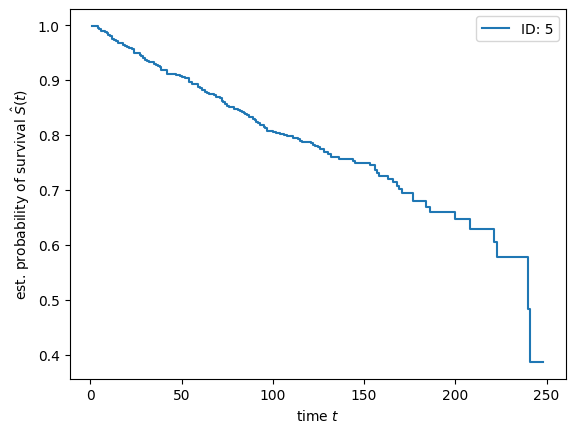

In [224]:
plot_sample_survival(estimator, X, 3, [5])
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_dummies.drop(['time_in_shelter_days', 'time_observed'], axis=1),
    data_dummies['time_observed'])
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = {
    'ols': LinearRegression(),
    'elnCV': ElasticNetCV(),
    'rforr': RandomForestRegressor(),
    'gb': GradientBoostingRegressor()
}
m_fit = {}
for k, v in models.items():
    m_fit[k] = v.fit(X_test, y_test)
m_pred = {}
for k, v in m_fit.items():
    m_pred[k] = v.predict(X_test)
from sklearn.metrics import mean_absolute_percentage_error as MAPE

n_pad = 70
for k, v in m_pred.items():
    print(f"{k} {(n_pad - len(k)) * '.'} MAPE value is {MAPE(y_test, v):.6f}")
MAPE(m_fit['gb'].predict(X_train), y_train)
m_fit['rforr'].score(X_train, y_train)
import seaborn as sns

sns.regplot(x=m_pred['rforr'], y=y_test, line_kws={'color': 'red'})